📊 Cargando datos...
Train shape: (692500, 21), Test shape: (296786, 20)
🧹 Limpiando datos...
🔧 Aplicando imputación avanzada...
⚙️ Creando nuevas características...
🔤 Aplicando codificación inteligente...
Procesando columna: ESTU_VALORMATRICULAUNIVERSIDAD
Procesando columna: FAMI_ESTRATOVIVIENDA
Procesando columna: FAMI_TIENEINTERNET
Procesando columna: FAMI_EDUCACIONPADRE
Procesando columna: FAMI_EDUCACIONMADRE
Procesando columna: ESTU_HORASSEMANATRABAJA
Procesando columna: ESTU_PAGOMATRICULAPROPIO
Procesando columna: ESTU_PRGM_DEPARTAMENTO
Procesando columna: ESTU_PRGM_ACADEMICO
🔍 Verificando tipos de datos...
Columnas no numéricas en X: ['FAMI_EDUCACIONPADRE_x_FAMI_EDUCACIONMADRE', 'FAMI_ESTRATOVIVIENDA_x_FAMI_TIENEINTERNET', 'ESTU_VALORMATRICULAUNIVERSIDAD_x_ESTU_PAGOMATRICULAPROPIO', 'FAMI_ESTRATOVIVIENDA_x_FAMI_EDUCACIONPADRE', 'ESTU_HORASSEMANATRABAJA_x_ESTU_PAGOMATRICULAPROPIO']
Columnas no numéricas en test: ['FAMI_EDUCACIONPADRE_x_FAMI_EDUCACIONMADRE', 'FAMI_ESTRATOVIVIENDA_x

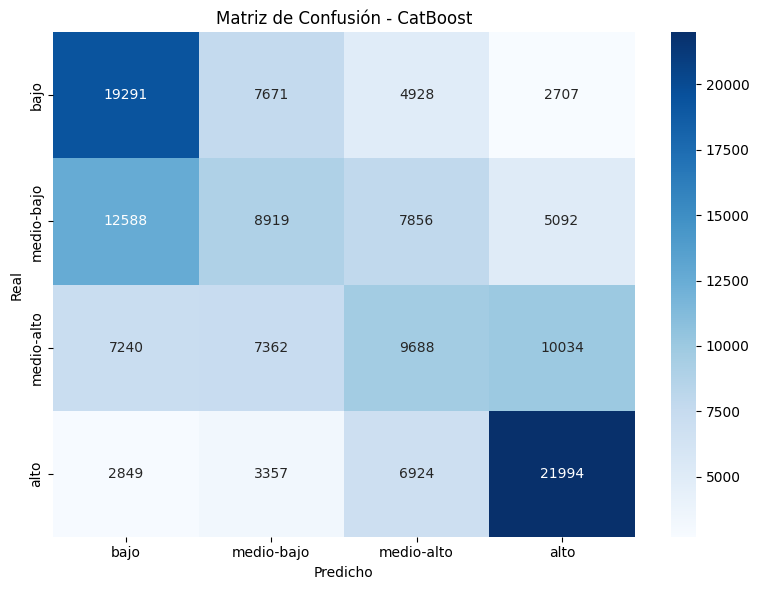


📄 Classification Report - CatBoost:
              precision    recall  f1-score   support

        bajo       0.46      0.56      0.50     34597
  medio-bajo       0.33      0.26      0.29     34455
  medio-alto       0.33      0.28      0.30     34324
        alto       0.55      0.63      0.59     35124

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500

🔮 Generando predicciones finales...
Forma de predicciones finales: (296786,)
Tipo de datos: <class 'numpy.ndarray'>
✅ Proceso completado exitosamente!
📦 Archivo 'submission_improved.csv' guardado con 296786 predicciones.
🎯 Modelo final utilizado: CatBoost
📊 Distribución de predicciones:
RENDIMIENTO_GLOBAL
alto          85443
bajo          89966
medio-alto    62707
medio-bajo    58670
Name: count, dtype: int64


In [17]:
# =============================================
# CÓDIGO MEJORADO PARA PREDICCIÓN DE RENDIMIENTO ACADÉMICO
# =============================================

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# =============================================
# 1. FUNCIONES DE UTILIDAD
# =============================================

def create_interaction_features(df, categorical_cols):
    """Crear características de interacción entre variables categóricas importantes"""
    df_copy = df.copy()
    
    # Interacciones importantes basadas en el dominio
    interactions = [
        ('FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE'),
        ('FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET'),
        ('ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_PAGOMATRICULAPROPIO'),
        ('FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE'),
        ('ESTU_HORASSEMANATRABAJA', 'ESTU_PAGOMATRICULAPROPIO')
    ]
    
    for col1, col2 in interactions:
        if col1 in df_copy.columns and col2 in df_copy.columns:
            df_copy[f'{col1}_x_{col2}'] = df_copy[col1].astype(str) + '_' + df_copy[col2].astype(str)
    
    return df_copy

def advanced_imputation(train_df, test_df, cols):
    """Imputación avanzada basada en similitud de características"""
    train_clean = train_df.copy()
    test_clean = test_df.copy()
    
    # Primero, imputación condicional por programa académico
    conditional_cols = [
        'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 
        'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE'
    ]
    
    for col in conditional_cols:
        if col in cols:
            # Para train
            train_clean[col] = train_clean.groupby('ESTU_PRGM_ACADEMICO')[col].transform(
                lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else 'Desconocido')
            )
            # Para test
            # Primero intentamos con el mismo programa
            test_clean[col] = test_clean.groupby('ESTU_PRGM_ACADEMICO')[col].transform(
                lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else np.nan)
            )
            # Si aún hay NaN, usar la moda global del train
            if test_clean[col].isnull().sum() > 0:
                global_mode = train_clean[col].mode().iloc[0] if len(train_clean[col].mode()) > 0 else 'Desconocido'
                test_clean[col] = test_clean[col].fillna(global_mode)
    
    # Imputación para las demás columnas
    for col in cols:
        if train_clean[col].isnull().sum() > 0:
            if col in conditional_cols:
                continue  # Ya procesadas
            
            # Para variables numéricas, usar mediana por programa
            if col in ['ESTU_HORASSEMANATRABAJA', 'ESTU_VALORMATRICULAUNIVERSIDAD']:
                train_clean[col] = train_clean.groupby('ESTU_PRGM_ACADEMICO')[col].transform(
                    lambda x: x.fillna(x.median())
                )
                test_clean[col] = test_clean.groupby('ESTU_PRGM_ACADEMICO')[col].transform(
                    lambda x: x.fillna(x.median())
                )
                # Fallback con mediana global
                if train_clean[col].isnull().sum() > 0:
                    global_median = train_clean[col].median()
                    train_clean[col] = train_clean[col].fillna(global_median)
                if test_clean[col].isnull().sum() > 0:
                    global_median = train_clean[col].median()
                    test_clean[col] = test_clean[col].fillna(global_median)
            else:
                # Para otras variables categóricas
                if train_clean[col].mode().empty:
                    mode_val = 'Desconocido'
                else:
                    mode_val = train_clean[col].mode().iloc[0]
                train_clean[col] = train_clean[col].fillna(mode_val)
                test_clean[col] = test_clean[col].fillna(mode_val)
    
    return train_clean, test_clean

def smart_encoding(train_df, test_df, cols, target_col=None):
    """Codificación inteligente basada en el tipo y cardinalidad de variables"""
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    
    # Variables de alta cardinalidad que se benefician de target encoding
    high_cardinality = ['ESTU_PRGM_DEPARTAMENTO', 'ESTU_PRGM_ACADEMICO']
    
    for col in cols:
        if col not in train_df.columns:
            continue
            
        print(f"Procesando columna: {col}")
        unique_count = train_df[col].nunique()
        
        if col in high_cardinality and target_col is not None:
            # Target encoding para variables de alta cardinalidad
            target_mean = train_df.groupby(col)[target_col].mean()
            global_mean = train_df[target_col].mean()
            
            # Aplicar suavizado (smoothing) para evitar overfitting
            counts = train_df[col].value_counts()
            lambda_param = 10  # parámetro de suavizado
            
            smoothed_means = {}
            for category in target_mean.index:
                count = counts.get(category, 0)
                smoothed_mean = (count * target_mean[category] + lambda_param * global_mean) / (count + lambda_param)
                smoothed_means[category] = smoothed_mean
            
            train_encoded[f'{col}_target_enc'] = train_df[col].map(smoothed_means).fillna(global_mean)
            test_encoded[f'{col}_target_enc'] = test_df[col].map(smoothed_means).fillna(global_mean)
            
            # Eliminar columna original
            train_encoded = train_encoded.drop(columns=[col])
            test_encoded = test_encoded.drop(columns=[col])
            
        else:
            # One-hot encoding para variables de baja cardinalidad
            if unique_count <= 20:  # Umbral para one-hot
                dummies_train = pd.get_dummies(train_df[col], prefix=col, dummy_na=False)
                dummies_test = pd.get_dummies(test_df[col], prefix=col, dummy_na=False)
                
                # Asegurar que test tenga las mismas columnas que train
                for dummy_col in dummies_train.columns:
                    if dummy_col not in dummies_test.columns:
                        dummies_test[dummy_col] = 0
                
                # Eliminar columnas extra en test que no están en train
                dummies_test = dummies_test.reindex(columns=dummies_train.columns, fill_value=0)
                
                # Eliminar columna original antes de concatenar
                train_encoded = train_encoded.drop(columns=[col])
                test_encoded = test_encoded.drop(columns=[col])
                
                train_encoded = pd.concat([train_encoded, dummies_train], axis=1)
                test_encoded = pd.concat([test_encoded, dummies_test], axis=1)
            else:
                # Label encoding para variables de muy alta cardinalidad
                le = LabelEncoder()
                train_encoded[f'{col}_label_enc'] = le.fit_transform(train_df[col].astype(str))
                
                # Para test, manejar categorías no vistas
                test_labels = []
                for val in test_df[col].astype(str):
                    if val in le.classes_:
                        test_labels.append(le.transform([val])[0])
                    else:
                        test_labels.append(-1)  # Valor para categorías no vistas
                test_encoded[f'{col}_label_enc'] = test_labels
                
                # Eliminar columna original
                train_encoded = train_encoded.drop(columns=[col])
                test_encoded = test_encoded.drop(columns=[col])
    
    return train_encoded, test_encoded

# =============================================
# 2. CARGA Y PREPARACIÓN DE DATOS
# =============================================

print("📊 Cargando datos...")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

# Columnas seleccionadas (ampliadas con nuevas características)
cols = [
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_HORASSEMANATRABAJA',
    'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO',
    'ESTU_PRGM_ACADEMICO'
]

# Mantener solo las columnas necesarias
train = train[['ID'] + cols + ['RENDIMIENTO_GLOBAL']].copy()
test = test[['ID'] + cols].copy()

# =============================================
# 3. LIMPIEZA DE DATOS MEJORADA
# =============================================

print("🧹 Limpiando datos...")

# Valores que representan "no sabe/no responde"
valores_raros = ['98', '99', '999', 98, 99, 999, -1, '-1']

for col in cols:
    # Convertir a string para manejo uniforme
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    
    # Reemplazar valores raros
    train[col] = train[col].replace([str(v) for v in valores_raros], np.nan)
    test[col] = test[col].replace([str(v) for v in valores_raros], np.nan)

# =============================================
# 4. IMPUTACIÓN AVANZADA
# =============================================

print("🔧 Aplicando imputación avanzada...")
train, test = advanced_imputation(train, test, cols)

# =============================================
# 5. INGENIERÍA DE CARACTERÍSTICAS
# =============================================

print("⚙️ Creando nuevas características...")

# Crear características de interacción
train = create_interaction_features(train, cols)
test = create_interaction_features(test, cols)

# Variables derivadas importantes
train['EDUCACION_PADRES_PROMEDIO'] = (
    pd.to_numeric(train['FAMI_EDUCACIONPADRE'], errors='coerce').fillna(0) + 
    pd.to_numeric(train['FAMI_EDUCACIONMADRE'], errors='coerce').fillna(0)
) / 2

test['EDUCACION_PADRES_PROMEDIO'] = (
    pd.to_numeric(test['FAMI_EDUCACIONPADRE'], errors='coerce').fillna(0) + 
    pd.to_numeric(test['FAMI_EDUCACIONMADRE'], errors='coerce').fillna(0)
) / 2

# Indicador de trabajo intensivo
train['TRABAJO_INTENSIVO'] = (
    pd.to_numeric(train['ESTU_HORASSEMANATRABAJA'], errors='coerce') > 20
).astype(int)

test['TRABAJO_INTENSIVO'] = (
    pd.to_numeric(test['ESTU_HORASSEMANATRABAJA'], errors='coerce') > 20
).astype(int)

# =============================================
# 6. CODIFICACIÓN INTELIGENTE
# =============================================

print("🔤 Aplicando codificación inteligente...")

# Mapear variable objetivo
mapa = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
inv_mapa = {v: k for k, v in mapa.items()}
train['target_encoded'] = train['RENDIMIENTO_GLOBAL'].map(mapa)

# Obtener columnas a codificar (excluyendo las ya creadas)
cols_to_encode = [col for col in cols if col in train.columns]

# Aplicar codificación inteligente
train_encoded, test_encoded = smart_encoding(
    train, test, cols_to_encode, 'target_encoded'
)

# Preparar datos finales
y = train_encoded['target_encoded']
X = train_encoded.drop(columns=['RENDIMIENTO_GLOBAL', 'target_encoded'])

# **CORRECCIÓN CRÍTICA**: Usar índices correctos para submission
test_ids = test['ID'].copy()  # Guardar IDs originales

# Asegurar que todas las columnas son numéricas
print("🔍 Verificando tipos de datos...")
print(f"Columnas no numéricas en X: {X.select_dtypes(include=['object']).columns.tolist()}")
print(f"Columnas no numéricas en test: {test_encoded.select_dtypes(include=['object']).columns.tolist()}")

# Convertir columnas categóricas restantes a numéricas
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        if col in test_encoded.columns:
            # Manejar valores no vistos en test
            test_labels = []
            for val in test_encoded[col].astype(str):
                if val in le.classes_:
                    test_labels.append(le.transform([val])[0])
                else:
                    test_labels.append(-1)
            test_encoded[col] = test_labels

for col in test_encoded.columns:
    if test_encoded[col].dtype == 'object':
        test_encoded[col] = pd.to_numeric(test_encoded[col], errors='coerce').fillna(-1)

# =============================================
# 7. SELECCIÓN DE CARACTERÍSTICAS AVANZADA
# =============================================

print("🎯 Seleccionando características óptimas...")

# Eliminar columnas con varianza muy baja
variance_selector = VarianceThreshold(threshold=0.01)
X_variance = pd.DataFrame(
    variance_selector.fit_transform(X),
    columns=X.columns[variance_selector.get_support()],
    index=X.index
)

test_variance = pd.DataFrame(
    variance_selector.transform(test_encoded),
    columns=X.columns[variance_selector.get_support()],
    index=test_encoded.index
)

# Selección híbrida: F-test + Mutual Information
selector_f = SelectKBest(score_func=f_classif, k=min(150, X_variance.shape[1]//2))
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(100, X_variance.shape[1]//3))

X_f = selector_f.fit_transform(X_variance, y)
X_mi = selector_mi.fit_transform(X_variance, y)

# Combinar características seleccionadas
selected_features_f = X_variance.columns[selector_f.get_support()]
selected_features_mi = X_variance.columns[selector_mi.get_support()]
selected_features = list(set(selected_features_f) | set(selected_features_mi))

X_final = X_variance[selected_features]
test_final = test_variance[selected_features]

print(f"Características finales seleccionadas: {len(selected_features)}")

# =============================================
# 8. MODELADO AVANZADO CON ENSEMBLE
# =============================================

print("🤖 Entrenando modelos avanzados...")

# División estratificada
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

# Modelo CatBoost optimizado
cat_params = {
    'iterations': 1000,
    'depth': 8,
    'learning_rate': 0.05,
    'l2_leaf_reg': 5,
    'bagging_temperature': 0.3,
    'random_strength': 0.5,
    'border_count': 128,
    'verbose': False,
    'random_state': 42,
    'early_stopping_rounds': 50
}

catboost_model = CatBoostClassifier(**cat_params)

# Modelo Random Forest optimizado
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Modelo Extra Trees para diversidad
et_model = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

# Gradient Boosting como alternativa a LightGBM
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    max_features='sqrt',
    random_state=42
)

# Entrenamiento de modelos individuales
print("Entrenando CatBoost...")
catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

print("Entrenando Random Forest...")
rf_model.fit(X_train, y_train)

print("Entrenando Extra Trees...")
et_model.fit(X_train, y_train)

print("Entrenando Gradient Boosting...")
gb_model.fit(X_train, y_train)

# Crear ensemble robusto con múltiples algoritmos
ensemble = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('random_forest', rf_model),
        ('extra_trees', et_model),
        ('gradient_boosting', gb_model)
    ],
    voting='soft'
)

print("Entrenando ensemble...")
ensemble.fit(X_train, y_train)

# =============================================
# 9. EVALUACIÓN MEJORADA
# =============================================

print("📈 Evaluando modelos...")

# Predicciones de validación
y_val_pred_cat = catboost_model.predict(X_val)
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_et = et_model.predict(X_val)
y_val_pred_gb = gb_model.predict(X_val)
y_val_pred_ensemble = ensemble.predict(X_val)

# Métricas
models_results = {
    'CatBoost': {
        'accuracy': accuracy_score(y_val, y_val_pred_cat),
        'f1_macro': f1_score(y_val, y_val_pred_cat, average='macro')
    },
    'Random Forest': {
        'accuracy': accuracy_score(y_val, y_val_pred_rf),
        'f1_macro': f1_score(y_val, y_val_pred_rf, average='macro')
    },
    'Extra Trees': {
        'accuracy': accuracy_score(y_val, y_val_pred_et),
        'f1_macro': f1_score(y_val, y_val_pred_et, average='macro')
    },
    'Gradient Boosting': {
        'accuracy': accuracy_score(y_val, y_val_pred_gb),
        'f1_macro': f1_score(y_val, y_val_pred_gb, average='macro')
    },
    'Ensemble': {
        'accuracy': accuracy_score(y_val, y_val_pred_ensemble),
        'f1_macro': f1_score(y_val, y_val_pred_ensemble, average='macro')
    }
}

print("\n🏆 RESULTADOS DE VALIDACIÓN:")
print("="*50)
for model_name, metrics in models_results.items():
    print(f"{model_name:15} - Accuracy: {metrics['accuracy']:.4f} | F1-macro: {metrics['f1_macro']:.4f}")

# **CORRECCIÓN DEL ERROR**: Definir correctamente el diccionario de modelos
all_models = {
    'CatBoost': catboost_model, 
    'Random Forest': rf_model, 
    'Extra Trees': et_model,
    'Gradient Boosting': gb_model,
    'Ensemble': ensemble
}

# Seleccionar el mejor modelo
best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['accuracy'])
best_model = all_models[best_model_name]

print(f"\n🎯 Mejor modelo: {best_model_name}")

# Cross-validation
cv_scores = cross_val_score(best_model, X_final, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

# Matriz de confusión del mejor modelo
best_model_predictions = {
    'CatBoost': y_val_pred_cat, 
    'Random Forest': y_val_pred_rf, 
    'Extra Trees': y_val_pred_et,
    'Gradient Boosting': y_val_pred_gb,
    'Ensemble': y_val_pred_ensemble
}
y_val_pred_best = best_model_predictions[best_model_name]

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bajo', 'medio-bajo', 'medio-alto', 'alto'],
            yticklabels=['bajo', 'medio-bajo', 'medio-alto', 'alto'])
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

print(f"\n📄 Classification Report - {best_model_name}:")
print(classification_report(y_val, y_val_pred_best, 
                          target_names=['bajo', 'medio-bajo', 'medio-alto', 'alto']))

# =============================================
# 10. PREDICCIÓN FINAL Y EXPORTACIÓN
# =============================================

print("🔮 Generando predicciones finales...")

# Reentrenar en todos los datos
best_model.fit(X_final, y)

# Predicción final
y_pred_final = best_model.predict(test_final)

# **CORRECCIÓN CRÍTICA**: Asegurar que las predicciones sean 1D
if y_pred_final.ndim > 1:
    y_pred_final = y_pred_final.ravel()

print(f"Forma de predicciones finales: {y_pred_final.shape}")
print(f"Tipo de datos: {type(y_pred_final)}")

# **CORRECCIÓN CRÍTICA**: Crear submission con IDs correctos
submission = pd.DataFrame({
    'ID': test_ids,  # Usar los IDs originales guardados
    'RENDIMIENTO_GLOBAL': [inv_mapa[pred] for pred in y_pred_final]
})

# Verificar que no hay valores nulos en las predicciones
if submission['RENDIMIENTO_GLOBAL'].isnull().sum() > 0:
    print("⚠️ Advertencia: Hay valores nulos en las predicciones. Rellenando con 'medio-bajo'...")
    submission['RENDIMIENTO_GLOBAL'] = submission['RENDIMIENTO_GLOBAL'].fillna('medio-bajo')

submission.to_csv("submission_improved.csv", index=False)

print("✅ Proceso completado exitosamente!")
print(f"📦 Archivo 'submission_improved.csv' guardado con {len(submission)} predicciones.")
print(f"🎯 Modelo final utilizado: {best_model_name}")
print(f"📊 Distribución de predicciones:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts().sort_index())